Id - an Id that represents a (Store, Date) duple within the test set

Store - a unique Id for each store

Sales - the turnover for any given day (this is what you are predicting)

Customers - the number of customers on a given day

Open - an indicator for whether the store was open: 0 = closed, 1 = open

StateHoliday - indicates a state holiday. Normally all stores, with few exceptions, are closed on state holidays. Note that all schools are closed on public holidays and weekends. a = public holiday, b = Easter holiday, c = Christmas, 0 = None

SchoolHoliday - indicates if the (Store, Date) was affected by the closure of public schools

StoreType - differentiates between 4 different store models: a, b, c, d

Assortment - describes an assortment level: a = basic, b = extra, c = extended

CompetitionDistance - distance in meters to the nearest competitor store

CompetitionOpenSince[Month/Year] - gives the approximate year and month of the time the nearest competitor was opened

Promo - indicates whether a store is running a promo on that day

Promo2 - Promo2 is a continuing and consecutive promotion for some stores: 0 = store is not participating, 1 = store is participating

Promo2Since[Year/Week] - describes the year and calendar week when the store started participating in Promo2

PromoInterval-describes the consecutive intervals Promo2 is started, naming the months the promotion is started anew. E.g. "Feb,May,Aug,Nov" means each round starts in February, May, August, November of any given year for that store

In [1]:
import bs4

In [4]:
# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

# Handle table like data and matrices
import numpy as np
import pandas as pd
import math

# Modelling Algorithm
from sklearn.tree import DecisionTreeRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# Modelling Helpers
#from sklearn.preprocessing import Imputer
#from sklearn.preprocessing import Normalizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFECV

# Visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

# Visualization Configuration
%matplotlib inline
mpl.style.use("ggplot")
sns.set_style("white")
plt.rcParams["figure.figsize"] = 12, 8

In [5]:
# Read the file
df = pd.read_csv("../Data/train.csv")
store = pd.read_csv("../Data/store.csv")
test = pd.read_csv("../Data/test.csv")

# check the first 5 rows
df.head()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
0,1,5,2015-07-31,5263,555,1,1,0,1
1,2,5,2015-07-31,6064,625,1,1,0,1
2,3,5,2015-07-31,8314,821,1,1,0,1
3,4,5,2015-07-31,13995,1498,1,1,0,1
4,5,5,2015-07-31,4822,559,1,1,0,1


<AxesSubplot:xlabel='Promo', ylabel='Sales'>

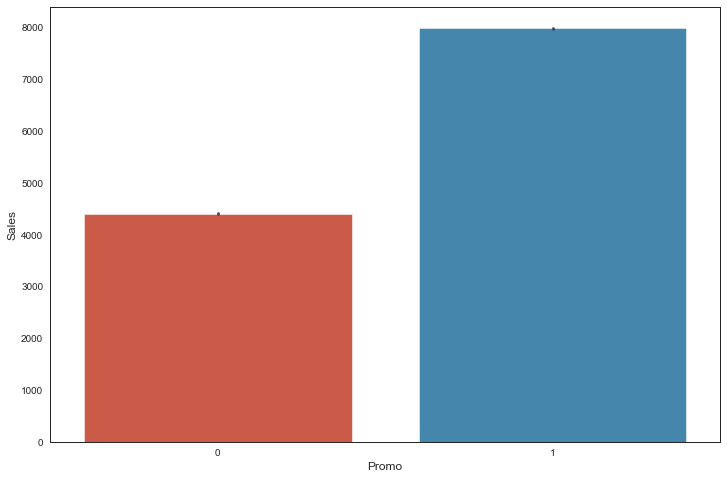

In [6]:
sns.barplot(x='Promo', y='Sales', data=df)

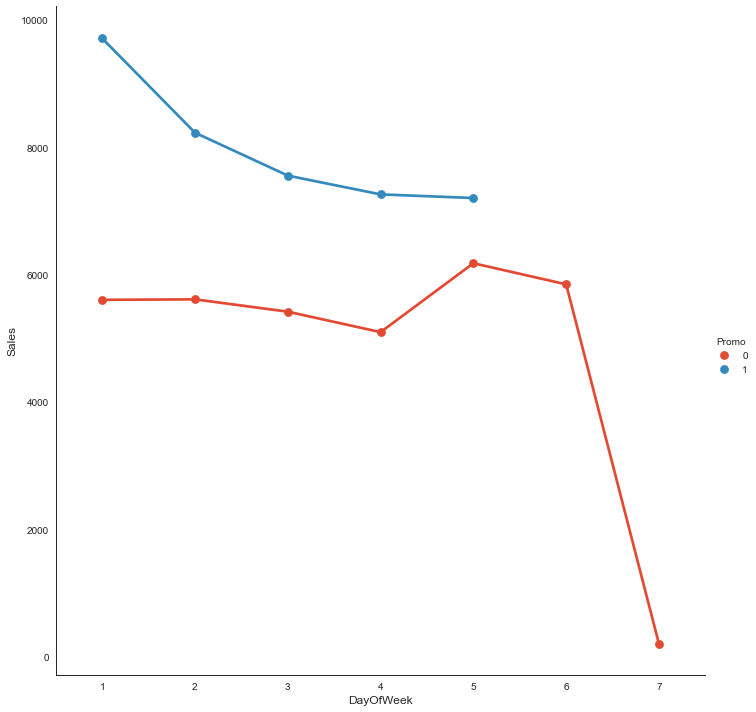

In [7]:
sns.factorplot(x='DayOfWeek', y='Sales', data=df, hue='Promo', size=10)

<AxesSubplot:xlabel='DayOfWeek', ylabel='Sales'>

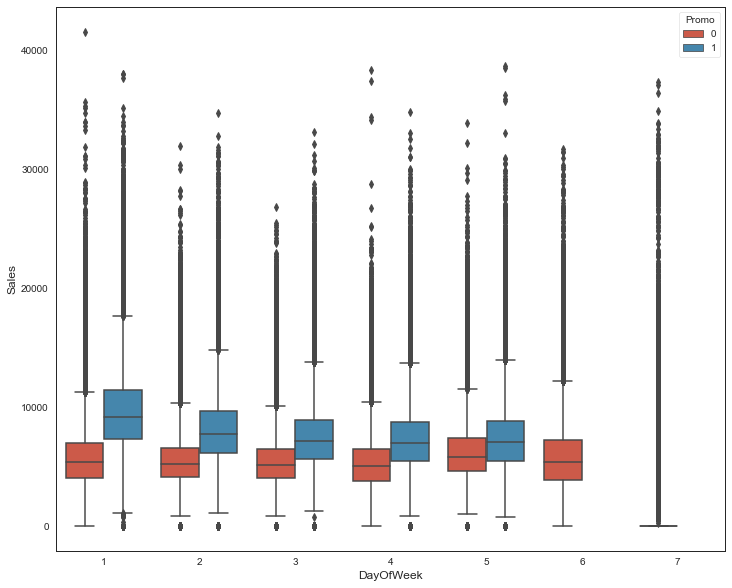

In [8]:
plt.rcParams['figure.figsize'] = (12,10)
sns.boxplot(x='DayOfWeek', y='Sales', data=df, hue='Promo')

Based on the visuals above, the first thing that jumps out here is the company dosen't run any promotiions on the weekends and in terms of comparison promotion has huge effect on sales on monday and very lesss on friday

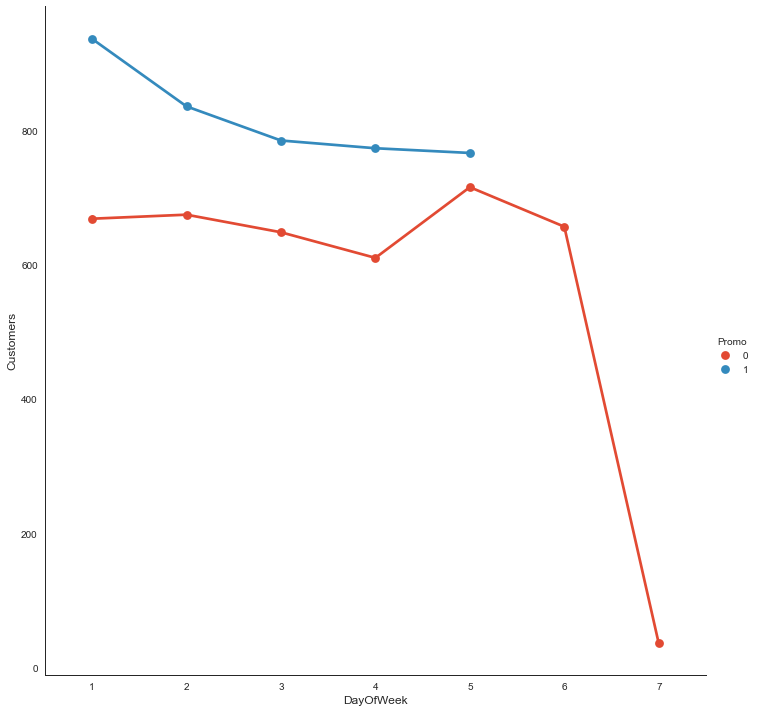

In [9]:
sns.factorplot(x='DayOfWeek', y='Customers', hue='Promo', data=df, size=10)

In [10]:
df.Date.unique()

array(['2015-07-31', '2015-07-30', '2015-07-29', '2015-07-28',
       '2015-07-27', '2015-07-26', '2015-07-25', '2015-07-24',
       '2015-07-23', '2015-07-22', '2015-07-21', '2015-07-20',
       '2015-07-19', '2015-07-18', '2015-07-17', '2015-07-16',
       '2015-07-15', '2015-07-14', '2015-07-13', '2015-07-12',
       '2015-07-11', '2015-07-10', '2015-07-09', '2015-07-08',
       '2015-07-07', '2015-07-06', '2015-07-05', '2015-07-04',
       '2015-07-03', '2015-07-02', '2015-07-01', '2015-06-30',
       '2015-06-29', '2015-06-28', '2015-06-27', '2015-06-26',
       '2015-06-25', '2015-06-24', '2015-06-23', '2015-06-22',
       '2015-06-21', '2015-06-20', '2015-06-19', '2015-06-18',
       '2015-06-17', '2015-06-16', '2015-06-15', '2015-06-14',
       '2015-06-13', '2015-06-12', '2015-06-11', '2015-06-10',
       '2015-06-09', '2015-06-08', '2015-06-07', '2015-06-06',
       '2015-06-05', '2015-06-04', '2015-06-03', '2015-06-02',
       '2015-06-01', '2015-05-31', '2015-05-30', '2015-

In [11]:
# check the unique data in the following column
cols = ["DayOfWeek", "SchoolHoliday", "StateHoliday", "Open", "Promo"]

for col in cols:
    print(col)
    print(df[col].unique())
    print("-------")

DayOfWeek
[5 4 3 2 1 7 6]
-------
SchoolHoliday
[1 0]
-------
StateHoliday
['0' 'a' 'b' 'c' 0]
-------
Open
[1 0]
-------
Promo
[1 0]
-------


In [12]:
# check the no of stores in the data
df['Store'].nunique()

1115

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 9 columns):
 #   Column         Non-Null Count    Dtype 
---  ------         --------------    ----- 
 0   Store          1017209 non-null  int64 
 1   DayOfWeek      1017209 non-null  int64 
 2   Date           1017209 non-null  object
 3   Sales          1017209 non-null  int64 
 4   Customers      1017209 non-null  int64 
 5   Open           1017209 non-null  int64 
 6   Promo          1017209 non-null  int64 
 7   StateHoliday   1017209 non-null  object
 8   SchoolHoliday  1017209 non-null  int64 
dtypes: int64(7), object(2)
memory usage: 69.8+ MB
